In [1]:
cd /SNS/users/lj7/dv/sns-chops/resolution/ARCS/

/SNS/users/lj7/dv/sns-chops/resolution/ARCS


In [2]:
#Program to load Vanadium or empty Can powder files and perform a constant-Q cut along the middle Q to look at energy resolution and intensity.
import matplotlib.pyplot as plt
from mantid import plots
from mantid.simpleapi import Load, ConvertToMD, BinMD, ConvertUnits, Rebin
from matplotlib.colors import LogNorm
import numpy as np
import mantid.simpleapi as msa
from mantid import mtd

In [3]:
from mcni.utils import conversion as C

In [4]:
%matplotlib notebook

In [5]:
# ls /SNS/ARCS/IPTS-21387/nexus/

In [6]:
RunNumbers=range(107476,107648)+range(108331,108457) # FC1
print(RunNumbers)
IPTS=21387
datadir="/SNS/ARCS/IPTS-"+str(IPTS)+"/shared/autoreduce/"

[107476, 107477, 107478, 107479, 107480, 107481, 107482, 107483, 107484, 107485, 107486, 107487, 107488, 107489, 107490, 107491, 107492, 107493, 107494, 107495, 107496, 107497, 107498, 107499, 107500, 107501, 107502, 107503, 107504, 107505, 107506, 107507, 107508, 107509, 107510, 107511, 107512, 107513, 107514, 107515, 107516, 107517, 107518, 107519, 107520, 107521, 107522, 107523, 107524, 107525, 107526, 107527, 107528, 107529, 107530, 107531, 107532, 107533, 107534, 107535, 107536, 107537, 107538, 107539, 107540, 107541, 107542, 107543, 107544, 107545, 107546, 107547, 107548, 107549, 107550, 107551, 107552, 107553, 107554, 107555, 107556, 107557, 107558, 107559, 107560, 107561, 107562, 107563, 107564, 107565, 107566, 107567, 107568, 107569, 107570, 107571, 107572, 107573, 107574, 107575, 107576, 107577, 107578, 107579, 107580, 107581, 107582, 107583, 107584, 107585, 107586, 107587, 107588, 107589, 107590, 107591, 107592, 107593, 107594, 107595, 107596, 107597, 107598, 107599, 107600,

# debug

In [7]:
RunNumber = RunNumbers[0]
path = '/SNS/ARCS/IPTS-%s/nexus/ARCS_%s.nxs.h5' % (IPTS, RunNumber)
w = msa.LoadEventNexus(path)
mons = msa.LoadNexusMonitors(path)

In [8]:
mons.getNumberHistograms()

2

In [9]:
RunParams=w.getRun()
Energy=RunParams["BL18:Chop:Skf0:EnergyUserReq"].getStatistics().mean

In [10]:
v = C.e2v(Energy)

In [11]:
LM1 = 11.831
t = LM1/v*1e6
print t

9563.22383736


In [12]:
mon1 = mons.getSpectrum(0)
tofs = mon1.getTofs()
weights = mon1.getWeights()
intensities, tofbbs = np.histogram(tofs, weights=weights, bins=100, range=(t*.8, t*1.2))
tofcenters = (tofbbs[1:]+tofbbs[:-1])/2

<IPython.core.display.Javascript object>


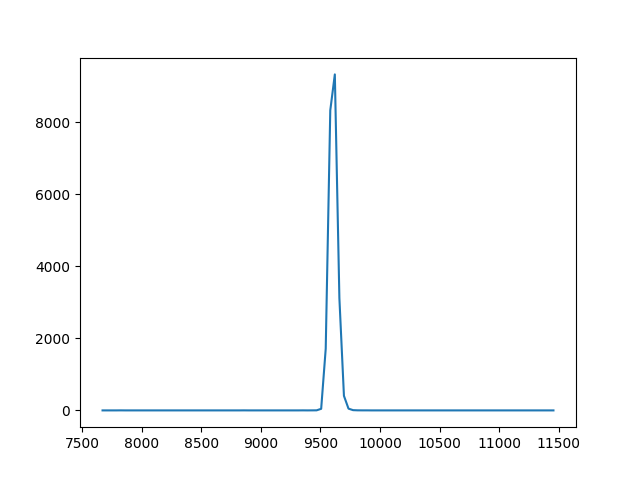

In [13]:
plt.figure()
plt.plot(tofcenters, intensities)

# gather data
**This can be skipped the 2nd time running this notebook**

In [7]:
LM1 = 11.831

In [10]:
%%time
PlotTag=0

data_table = {}

import tqdm
for RunNumber in tqdm.tqdm(RunNumbers):
    # print (RunNumber)
    path = '/SNS/ARCS/IPTS-%s/nexus/ARCS_%s.nxs.h5' % (IPTS, RunNumber)
    w = msa.LoadEventNexus(path)
    mons = msa.LoadNexusMonitors(path)
    RunParams=w.getRun()
    Energy=RunParams["BL18:Chop:Skf0:EnergyUserReq"].getStatistics().mean
    v = C.e2v(Energy)
    t = LM1/v*1e6
    mon1 = mons.getSpectrum(0)
    tofs = mon1.getTofs()
    weights = mon1.getWeights()
    intensities, tofbbs = np.histogram(tofs, weights=weights, bins=100, range=(t*.8, t*1.2))
    tofcenters = (tofbbs[1:]+tofbbs[:-1])/2
    totscatt = w.getNumberEvents()
    duration = RunParams['duration'].value
    data_table[RunNumber] = (tofcenters, intensities), totscatt, duration
    # break
    continue

100%|██████████| 298/298 [32:48<00:00,  5.71s/it] 

CPU times: user 20min 17s, sys: 52.8 s, total: 21min 10s
Wall time: 32min 48s


## Save

In [11]:
import pickle as pkl

In [12]:
pkl.dump(data_table, open('V_Cali_MonitorInt_FC1_2018_v2_datatable.pkl', 'w'))

# Load data from saved file

In [13]:
data_table = pkl.load(open('./V_Cali_MonitorInt_FC1_2018_v2_datatable.pkl'))

examine data

<IPython.core.display.Javascript object>


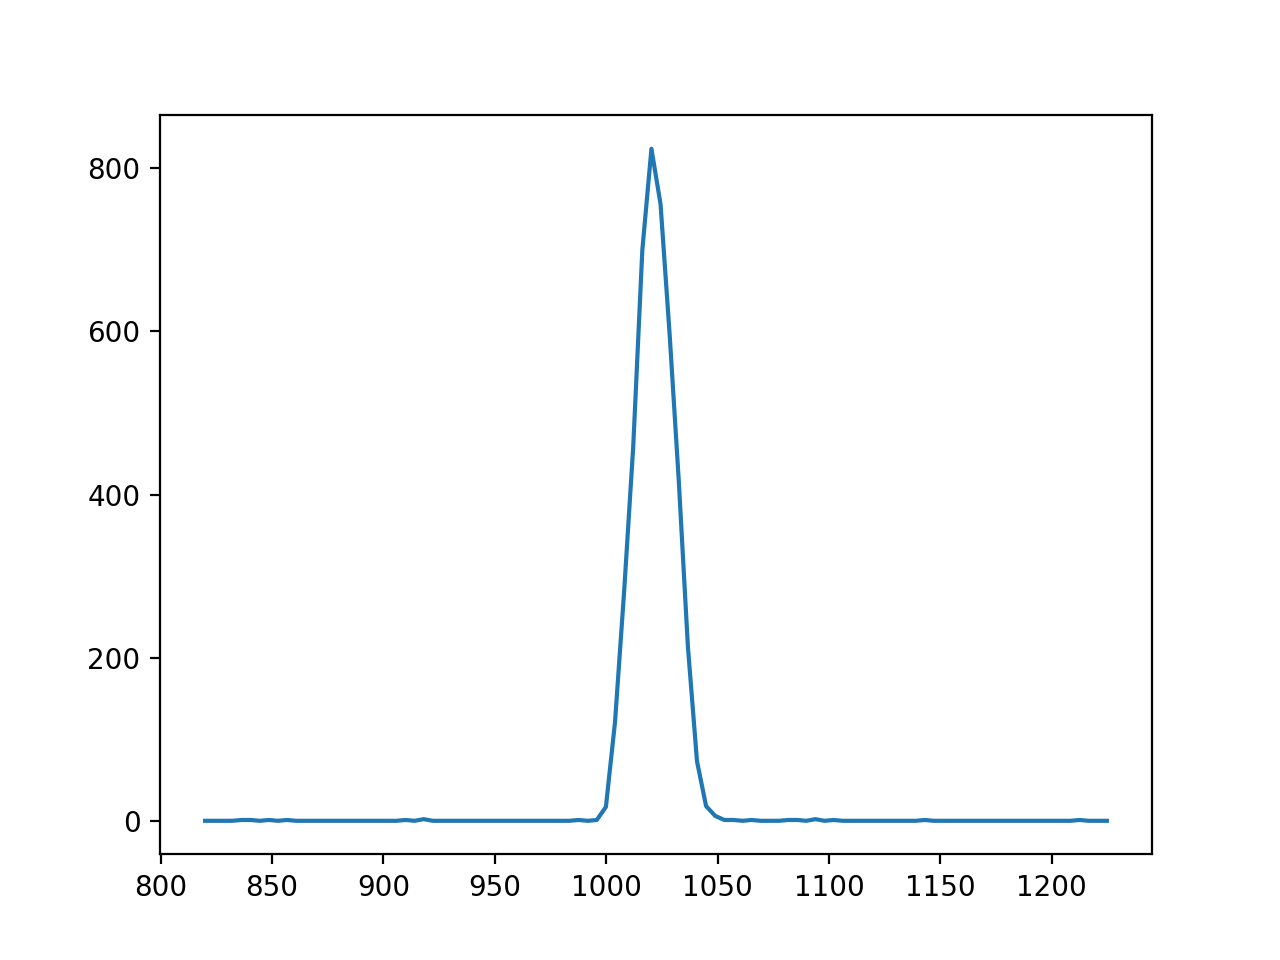

In [14]:
(tof,I), totscatt, duration  =  data_table[RunNumbers[50]]
plt.figure()
plt.plot(tof, I)

In [16]:
intensity_data = [(k, I.sum(), totscatt, duration) for k, ((tof, I), totscatt, duration) in data_table.items()]

In [17]:
intensity_data = np.array(intensity_data)

In [18]:
np.savetxt('V_Cali_MonitorInt_FC1_2018_v2.dat', intensity_data)

# Inspect 

In [24]:
import sys, os
sys.path.insert(0, os.path.abspath('./PyChop/'))

In [25]:
import Vdata2018
reload(Vdata2018)

<module 'Vdata2018' from '/SNS/users/lj7/dv/sns-chops/resolution/ARCS/PyChop/Vdata2018.pyc'>

In [26]:
expdata = Vdata2018.ExpData(os.path.join(Vdata2018.datadir, './V_Cali_Int_Res_FC1_2018_v2.dat'))

reading data. please wait...
  done


In [27]:
Ei = 250.
condition = np.isclose(expdata.vdata.Energy, Ei)

In [28]:
expdata.chopper_freqs[condition]

array([ 120.,  240.,  360.,  480.,  600.,  180.,  300.,  420.,  540.,   60.])

In [29]:
expdata.vdata.RunNumber[condition]

1      107521.0
27     107547.0
53     107573.0
80     107600.0
107    107627.0
170    108373.0
173    108376.0
176    108379.0
179    108382.0
270    107492.0
Name: RunNumber, dtype: float64

<IPython.core.display.Javascript object>


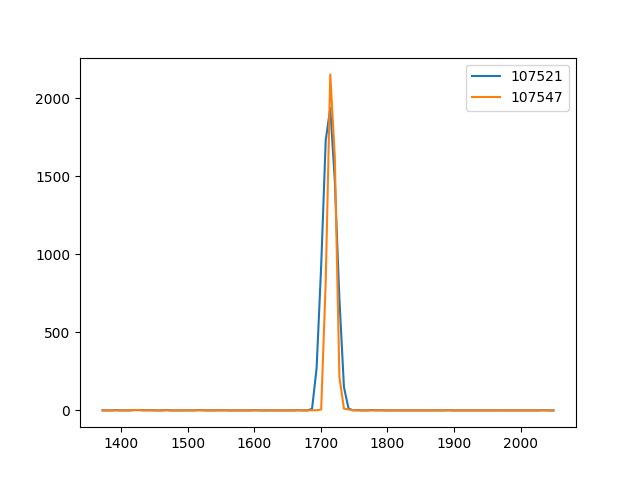

7251.0
4878.0


In [30]:
plt.figure()
for run in [107521, 107547]:
    tof,I =  data_table[run]
    plt.plot(tof, I, label=run)
    print I.sum()
plt.legend()